# Create training data

Schema:
* id: (int) unique ID for each doc
* tokens: (list) words or groups of words 
* bboxes: (list) bounding box for each token (x1, y1, x2, y2)
* ner_tags: (int) the entity tag corresponding to each token
* image: PIL Image

See [FUNSD dataset](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3) as an example

Tutorials and notebooks:
* [Fine-tuning on custom dataset tutorial](https://medium.com/@matt.noe/tutorial-how-to-train-layoutlm-on-a-custom-dataset-with-hugging-face-cda58c96571c)
* [Fine-tuning LayoutLMv3 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb#scrollTo=cqcq7rzlVDOE)
* [Fine-tuning LayoutLMv2 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/Fine_tuning_LayoutLMv2ForTokenClassification_on_FUNSD_using_HuggingFace_Trainer.ipynb)

In [3]:
!pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)


In [4]:
import json
from typing import Any, Optional, Union

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from datasets import Dataset, ClassLabel, Features, Sequence, Value, Array2D, Array3D, load_metric
import torch
from transformers import AutoProcessor

from mozilla_sec_eia.utils import GCSArchive

# PDF text extraction utility functions

In [5]:
# copied from well gas project wellgas/features/extract_text.py
def extract_pdf_data_from_page(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse PDF page data."""
    contents = _parse_page_contents(page)
    meta = {
        "rotation_degrees": [page.rotation],
        "origin_x_pdf_coord": [page.rect[0]],
        "origin_y_pdf_coord": [page.rect[1]],
        "width_pdf_coord": [page.rect[2] - page.rect[0]],
        "height_pdf_coord": [page.rect[3] - page.rect[1]],
        "has_images": [not contents["image"].empty],
        "has_text": [not contents["pdf_text"].empty],
        "page_num": [page.number],
    }
    if not contents["image"].empty:
        img_area = (
            contents["image"]
            .eval(
                "((bottom_right_x_pdf - top_left_x_pdf)"
                " * (bottom_right_y_pdf - top_left_y_pdf))"
            )
            .sum()
        )
    else:
        img_area = 0
    total_area = meta["width_pdf_coord"][0] * meta["height_pdf_coord"][0]

    meta["image_area_frac"] = [np.float32(img_area / total_area)]
    meta_df = pd.DataFrame(meta).astype(
        {
            "rotation_degrees": np.int16,
            "origin_x_pdf_coord": np.float32,
            "origin_y_pdf_coord": np.float32,
            "width_pdf_coord": np.float32,
            "height_pdf_coord": np.float32,
            "has_images": "boolean",
            "has_text": "boolean",
            "page_num": np.int16,
            "image_area_frac": np.float32,
        }
    )
    meta = dict(page=meta_df)
    for df in contents.values():  # add ID fields
        if not df.empty:
            df["page_num"] = np.int16(page.number)
    return contents | meta


def _parse_page_contents(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse page contents using fitz.TextPage."""
    flags = fitz.TEXTFLAGS_DICT
    # try getting only words
    textpage = page.get_textpage(flags=flags)
    content = textpage.extractDICT()
    words = textpage.extractWORDS()
    images = []
    text = []
    for block in content["blocks"]:
        if block["type"] == 0:
            # skip over text, we'll parse it by word blocks
            continue
        elif block["type"] == 1:
            images.append(_parse_image_block(block))
        else:
            raise ValueError(f"Unknown block type: {block['type']}")
    for word_block in words:
        parsed = _parse_word_block(word_block)
        if not parsed.empty:
            text.append(parsed)
    if text:
        text = pd.concat(text, axis=0, ignore_index=True)
    else:
        text = pd.DataFrame()
    if images:
        images = pd.concat(
            (pd.DataFrame(image) for image in images), axis=0, ignore_index=True
        )
    else:
        images = pd.DataFrame()
        
    return dict(pdf_text=text, image=images)


def _parse_image_block(img_block: dict[str, Any]) -> pd.DataFrame:
    """Parse an image block from a fitz.TextPage.extractDICT() output."""
    top_left_x_pdf, top_left_y_pdf, bottom_right_x_pdf, bottom_right_y_pdf = img_block[
        "bbox"
    ]
    dpi = min(
        img_block["xres"], img_block["yres"]
    )  # should be equal; min() just in case
    out = pd.DataFrame(
        {
            "img_num": [img_block["number"]],
            "dpi": [dpi],
            "top_left_x_pdf": [top_left_x_pdf],
            "top_left_y_pdf": [top_left_y_pdf],
            "bottom_right_x_pdf": [bottom_right_x_pdf],
            "bottom_right_y_pdf": [bottom_right_y_pdf],
        }
    ).astype(
        {
            "img_num": np.int16,
            "dpi": np.int16,
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out

def _parse_word_block(word_block: tuple) -> pd.DataFrame:
    """Parse a word block from a fitz.TextPage.extractWORDS() output."""
    out = {
        "top_left_x_pdf": [word_block[0]],
        "top_left_y_pdf": [word_block[1]],
        "bottom_right_x_pdf": [word_block[2]],
        "bottom_right_y_pdf": [word_block[3]],
        "text": [word_block[4]],
        "block_num": [word_block[5]],
        "line_num": [word_block[6]],
        "word_num": [word_block[7]]
    }
    out = pd.DataFrame(out).astype(
        {
            "block_num": np.int16,
            "line_num": np.int16,
            "word_num": np.int16,
            "text": "string",
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out

def _frac_normal_ascii(text: Union[str, bytes]) -> float:
    """Fraction of characters that are normal ASCII characters."""
    # normal characters, from space to tilde, plus whitespace
    # see https://www.asciitable.com/
    sum_ = 0
    if isinstance(text, bytes):
        text = text.decode("utf-8")
    for char in text:
        if (32 <= ord(char) <= 126) or char in "\t\n":
            sum_ += 1
    return sum_ / len(text)


In [6]:

def _render_page(
    pg: fitz.Page, dpi=150, clip: Optional[fitz.Rect] = None
) -> Image.Image:
    """Render a page of a PDF as a PIL.Image object.

    Args:
        pg (fitz.Page): a page of a PDF
        dpi (int, optional): image resolution in pixels per inch. Defaults to 150.
        clip (Optional[fitz.Rect], optional): Optionally render only a subset of the
            page. Defined in PDF coordinates. Defaults to None, which renders the
            full page.

    Returns:
        Image.Image: PDF page rendered as a PIL.Image object
    """
    # 300 dpi is what tesseract recommends. PaddleOCR seems to do fine with half that.
    render: fitz.Pixmap = pg.get_pixmap(dpi=dpi, clip=clip)  # type: ignore
    img = _pil_img_from_pixmap(render)
    return img


def _pil_img_from_pixmap(pix: fitz.Pixmap) -> Image.Image:
    """Convert pyMuPDF Pixmap object to PIL.Image object.

    For some reason pyMuPDF (aka fitz) lets you save images using PIL, but does not
    have any function to convert to PIL objects. Clearly they do this conversion
    internally; they should just expose it. Instead, I had to copy it out from their
    source code.

    Args:
        pix (fitz.Pixmap): a rendered Pixmap

    Returns:
        Image: a PIL.Image object
    """
    # pyMuPDF source code on GitHub is all in SWIG (some kind of C to python code
    # generator) and is unreadable to me. So you have to inspect your local .py files.
    # Adapted from the Pixmap.pil_save method in python3.9/site-packages/fitz/fitz.py
    # I just replaced instances of "self" with "pix"
    cspace = pix.colorspace
    if cspace is None:
        mode = "L"
    elif cspace.n == 1:
        mode = "L" if pix.alpha == 0 else "LA"
    elif cspace.n == 3:
        mode = "RGB" if pix.alpha == 0 else "RGBA"
    else:
        mode = "CMYK"

    img = Image.frombytes(mode, (pix.width, pix.height), pix.samples)
    return img

In [7]:
PDF_POINTS_PER_INCH = 72  # I believe this is standard for all PDFs

def pil_to_cv2(image: Image.Image) -> np.ndarray:  # noqa: C901
    """Convert a PIL Image to an OpenCV image (numpy array)."""
    # copied from https://gist.github.com/panzi/1ceac1cb30bb6b3450aa5227c02eedd3
    # This covers the common modes, is not exhaustive.
    mode = image.mode
    new_image: np.ndarray
    if mode == "1":
        new_image = np.array(image, dtype=np.uint8)
        new_image *= 255
    elif mode == "L":
        new_image = np.array(image, dtype=np.uint8)
    elif mode == "LA" or mode == "La":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "RGB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "RGBA":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "LAB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_LAB2BGR)
    elif mode == "HSV":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2BGR)
    elif mode == "YCbCr":
        # XXX: not sure if YCbCr == YCrCb
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_YCrCb2BGR)
    elif mode == "P" or mode == "CMYK":
        new_image = np.array(image.convert("RGB"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "PA" or mode == "Pa":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    else:
        raise ValueError(f"unhandled image color mode: {mode}")

    return new_image


def cv2_to_pil(img: np.ndarray) -> Image.Image:
    """Create PIL Image from numpy pixel array."""
    if len(img.shape) == 2:  # single channel, AKA grayscale
        return Image.fromarray(img)
    else:  # only handle BGR for now
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def display_img_array(img: np.ndarray, figsize=(5, 5), **kwargs):
    """Plot image array for jupyter sessions."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:  # grayscale
        return plt.imshow(img, cmap="gray", vmin=0, vmax=255, **kwargs)
    else:
        return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), **kwargs)


def overlay_bboxes(
    img: np.ndarray, bboxes: np.ndarray, color=(255, 0, 0)
) -> np.ndarray:
    """Overlay bounding boxes of shape N x 4 (x0, y0, x1, y1) on an image."""
    img = img.copy()
    for box in np.round(bboxes, 0).astype(np.int32):  # float to int just in case:
        x0, y0, x1, y1 = box
        cv2.rectangle(img, (x0, y0), (x1, y1), color=color, thickness=1)
    return img


def pdf_coords_to_pixel_coords(coords: np.ndarray, dpi: int) -> np.ndarray:
    """Convert PDF coordinates to pixel coordinates."""
    # For arbitrary PDFs you would need to subtract the origin in PDF coordinates,
    # but since you create these PDFs, you know the origin is (0, 0).
    out = coords * dpi / PDF_POINTS_PER_INCH
    return out

# Create PDFs of Ex. 21's

In [81]:
archive = GCSArchive()
md = archive.get_metadata()

In [ ]:
tucson_md = md[md["Company Name"].str.contains("TUCSON")].iloc[[0]]
tucson_filing = archive.get_filings(tucson_md)

In [54]:
with open("tucson_electric.pdf", "wb") as file:
    tucson_filing[0].ex_21.save_as_pdf(file)

In [57]:
# get some random PDFs
sample = md[md.exhibit_21_version.notnull()].sample(3)
filings = archive.get_filings(sample)
for i in range(len(filings)):
    with open(f"test_{i}.pdf", "wb") as file:
        filings[i].ex_21.save_as_pdf(file)

# Demo with one doc

In [8]:
src_path = Path("./wisconsin_electric.pdf")
assert src_path.exists()

In [9]:
# from file
doc = fitz.Document(str(src_path))
doc.is_pdf

True

In [10]:
# from bytes
_bytes = src_path.read_bytes()
from io import BytesIO
doc = fitz.open(stream=BytesIO(_bytes), filetype="pdf")
doc.is_pdf

True

### Extract Text Bboxes

In [11]:
pg = doc[0]
extracted = extract_pdf_data_from_page(pg)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [12]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((106, 9), (0, 0), (1, 9))

In [13]:
txt

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num
0,504.791168,83.474442,541.465210,98.621445,Exhibit,0,0,0,0
1,544.523193,83.474442,565.929260,98.621445,21.1,0,0,1,0
2,184.882263,127.074478,248.440277,142.221481,WISCONSIN,1,0,0,0
3,251.498276,127.074478,306.498260,142.221481,ELECTRIC,1,0,1,0
4,309.556274,127.074478,351.114288,142.221481,POWER,1,0,2,0
...,...,...,...,...,...,...,...,...,...
101,167.466446,432.646484,212.476440,446.386475,subsidiary,10,2,5,0
102,215.256439,432.646484,223.596436,446.386475,of,10,2,6,0
103,226.376434,432.646484,249.706451,446.386475,WEC,10,2,7,0
104,252.486450,432.646484,284.166443,446.386475,Energy,10,2,8,0


### Label the entities

In [14]:
# do we actually need the headers?
id_to_label_full = {
    0: "O",
    1: "B-Header_Subsidiary",
    2: "I-Header_Subsidiary",
    3: "B-Body_Subsidiary",
    4: "I-Body_Subsidiary",
    5: "B-Header_Loc",
    6: "I-Header_Loc",
    7: "B-Body_Loc",
    8: "I-Body_Loc",
    9: "B-Header_Own_Per",
    10: "I-Header_Own_Per",
    11: "B-Body_Own_Per",
    12: "I-Body_Own_Per"
}
id_to_label_small = {
    0: "O",
    1: "B-Subsidiary",
    2: "I-Subsidiary",
    3: "B-Loc",
    4: "I-Loc",
    5: "B-Own_Per",
    6: "I-Own_Per"
}


In [15]:
label_col = "ner_tag"

In [16]:
txt.loc[:, label_col] = 0

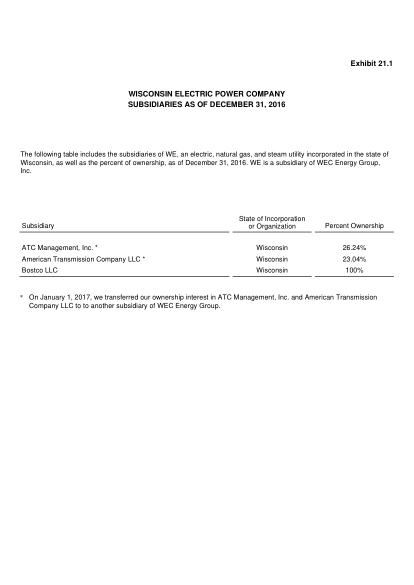

In [17]:
pg_img = _render_page(pg, dpi=50)  # small dpi for notebook display
pg_img

In [18]:
full_pg_img = _render_page(pg)  # full image for dataset

In [19]:
image_filename = "wisconsin_electric.png"

In [20]:
full_pg_img.save(image_filename)

In [21]:
id_to_label_small

{0: 'O',
 1: 'B-Subsidiary',
 2: 'I-Subsidiary',
 3: 'B-Loc',
 4: 'I-Loc',
 5: 'B-Own_Per',
 6: 'I-Own_Per'}

In [22]:
txt.iloc[70:90]

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num,ner_tag
70,138.586472,365.576477,181.376465,379.316467,Company,8,0,2,0,0
71,184.156464,365.576477,202.496460,379.316467,LLC,8,0,3,0,0
72,205.276459,365.576477,209.166458,379.316467,*,8,0,4,0,0
73,369.109741,365.576477,414.669739,379.316467,Wisconsin,8,2,0,0,0
74,493.422943,365.576477,527.332947,379.316467,23.04%,8,4,0,0,0
75,31.346460,381.576477,61.916462,395.316467,Bostco,9,0,0,0,0
76,64.696465,381.576477,83.036469,395.316467,LLC,9,0,1,0,0
77,369.109741,381.576477,414.669739,395.316467,Wisconsin,9,2,0,0,0
78,497.592926,381.576477,523.162964,395.316467,100%,9,4,0,0,0
79,28.346460,420.446472,33.346458,433.786469,*,10,0,0,0,0


In [23]:
label_to_indices = {
    1: [62, 68, 75],
    2: [63, 64, 69, 70, 71, 76],
    3: [66, 73, 77],
    5: [67, 74, 78]
}   

In [24]:
for label, indices in label_to_indices.items():
    txt.loc[indices, label_col] = label
txt[label_col] = txt[label_col].astype(int)

In [25]:
id_to_color = {
    0: (128, 128, 128),
    1: (0, 128, 0),
    2: (0, 255, 0),
    3: (255, 0, 255),
    4: (128, 0, 128),
    5: (128, 128, 0),
    6: (255, 0, 0)
}   

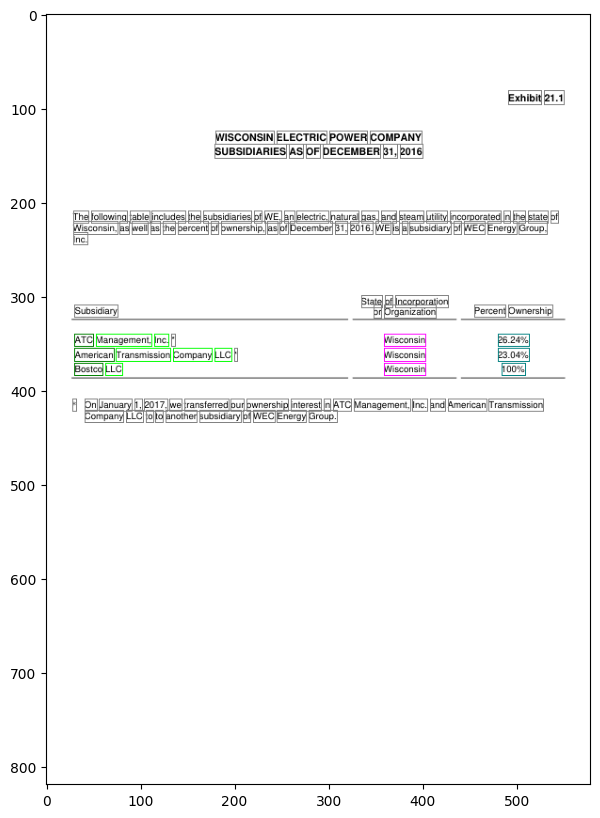

In [26]:
# fix to overlay boxes on pdf and color code it by label
coord_cols = ['top_left_x_pdf', 'top_left_y_pdf', 'bottom_right_x_pdf', 'bottom_right_y_pdf']
dpi = 70
display_img = np.array(_render_page(pg, dpi=dpi))
for tag in id_to_label_small.keys():
    subset = txt[txt[label_col] == tag]
    bboxes = pdf_coords_to_pixel_coords(subset[coord_cols].values, dpi=dpi)
    display_img = overlay_bboxes(display_img, bboxes, color=id_to_color[tag])
display_img_array(display_img, figsize=(10, 10))

In [27]:
txt.loc[:, "id"] = 0
output_df = pd.DataFrame()
output_df = pd.concat([output_df, txt])

In [28]:
output_df

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num,ner_tag,id
0,504.791168,83.474442,541.465210,98.621445,Exhibit,0,0,0,0,0,0
1,544.523193,83.474442,565.929260,98.621445,21.1,0,0,1,0,0,0
2,184.882263,127.074478,248.440277,142.221481,WISCONSIN,1,0,0,0,0,0
3,251.498276,127.074478,306.498260,142.221481,ELECTRIC,1,0,1,0,0,0
4,309.556274,127.074478,351.114288,142.221481,POWER,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101,167.466446,432.646484,212.476440,446.386475,subsidiary,10,2,5,0,0,0
102,215.256439,432.646484,223.596436,446.386475,of,10,2,6,0,0,0
103,226.376434,432.646484,249.706451,446.386475,WEC,10,2,7,0,0,0
104,252.486450,432.646484,284.166443,446.386475,Energy,10,2,8,0,0,0


# Put into demo doc into JSON Format for Label Studio

In [31]:
pil_to_cv2(full_pg_img).shape

(1754, 1241, 3)

In [35]:
txt.iloc[62]

top_left_x_pdf          31.34646
top_left_y_pdf        349.576477
bottom_right_x_pdf     51.346462
bottom_right_y_pdf    363.316467
text                         ATC
block_num                      7
line_num                       0
word_num                       0
page_num                       0
ner_tag                        1
id                             0
Name: 62, dtype: object

In [69]:
x_norm = 100/pg_meta.width_pdf_coord.iloc[0]
y_norm = 100/pg_meta.height_pdf_coord.iloc[0]
x_norm, y_norm

(0.16798942273629794, 0.11878039560889525)

In [80]:
annotation_json = {
   "data": {
      "ocr": "gs://labeled-ex21-filings/wisconsin_electric.png" # how to fill with an f string?
   },
   "annotations": [],
   "predictions": [
      {
         "model_version": "v1.0",
         "result": [
            {
              "original_width": 1241,
              "original_height": 1754,
              "image_rotation": 0,
              "value": {
                "x": 31.34646 * x_norm,
                "y": 349.576477 * y_norm,
                "width": 20.000002 * x_norm,
                "height": 13.73999 * y_norm,
                "rotation": 0
              },
                "id": "bb1",
                "from_name": "bbox",
                "to_name": "image",
                "type": "rectangle",
                "origin": "manual"
            },
            {
               "original_width": 1241,
               "original_height": 1754,
               "image_rotation": 0,
               "value": {
                  "x": 31.34646 * x_norm,
                  "y": 349.576477 * y_norm,
                  "width": 20.000002 * x_norm,
                  "height": 13.73999 * y_norm,
                  "rotation": 0,
                  "text": [
                     "ATC"
                  ]
               },
                "id": "bb1",
                "from_name": "transcription",
                "to_name": "image",
                "type": "textarea",
                "origin": "manual"
            },
         ],
      }
    ],
}

In [79]:
with open('wisconsin_electric.json', 'w') as fp:
    json.dump(annotation_json, fp)

# Label Another

In [80]:
src_path = Path("./test_0.pdf")
assert src_path.exists()

In [81]:
# from file
doc = fitz.Document(str(src_path))
doc.is_pdf

True

In [82]:
# from bytes
_bytes = src_path.read_bytes()
from io import BytesIO
doc = fitz.open(stream=BytesIO(_bytes), filetype="pdf")
doc.is_pdf

True

In [83]:
pg2 = doc[0]
extracted = extract_pdf_data_from_page(pg2)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [84]:
txt2 = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt2.shape, img_info.shape, pg_meta.shape

((36, 9), (0, 0), (1, 9))

In [85]:
txt2.loc[:, label_col] = 0

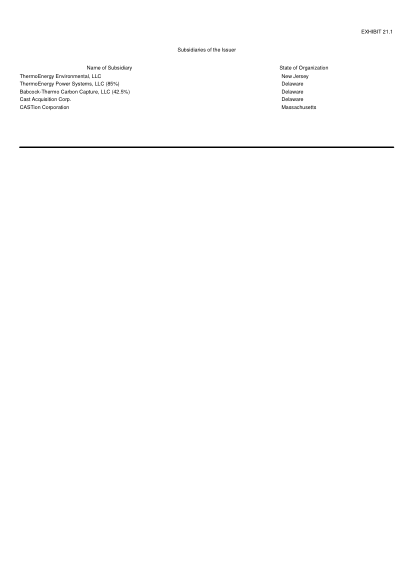

In [86]:
pg_img2 = _render_page(pg2, dpi=50)  # small dpi for notebook display
pg_img2

In [87]:
full_pg_img2 = _render_page(pg2)  # full image for dataset

In [33]:
id_to_label_small

{0: 'O',
 1: 'B-Subsidiary',
 2: 'I-Subsidiary',
 3: 'B-Loc',
 4: 'I-Loc',
 5: 'B-Own_Per',
 6: 'I-Own_Per'}

In [88]:
txt2

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num,ner_tag
0,520.074158,39.918999,549.249146,50.223999,EXHIBIT,0,0,0,0,0
1,551.334167,39.918999,565.929138,50.223999,21.1,0,0,1,0,0
2,255.536560,66.418999,296.381561,76.723999,Subsidiaries,1,0,0,0,0
3,298.466553,66.418999,304.721558,76.723999,of,1,0,1,0,0
4,306.806549,66.418999,317.231567,76.723999,the,1,0,2,0,0
5,319.316559,66.418999,339.739075,76.723999,Issuer,1,0,3,0,0
6,124.887550,91.919014,144.890045,102.224014,Name,2,0,0,0,0
7,146.975052,91.919014,153.230057,102.224014,of,2,0,1,0,0
8,155.315048,91.919014,190.325027,102.224014,Subsidiary,2,0,2,0,0
9,402.441803,91.919014,419.954315,102.224014,State,2,2,0,0,0


In [118]:
label_to_indices = {
    1: [12, 17, 23, 29, 33],
    2: [13, 14, 18, 19, 20, 24, 25, 26, 30, 31, 34],
    3: [15, 22, 28, 32, 35],
    4: [16],
    5: [21, 27]
}

In [119]:
for label, indices in label_to_indices.items():
    txt2.loc[indices, label_col] = label
txt2[label_col] = txt2[label_col].astype(int)

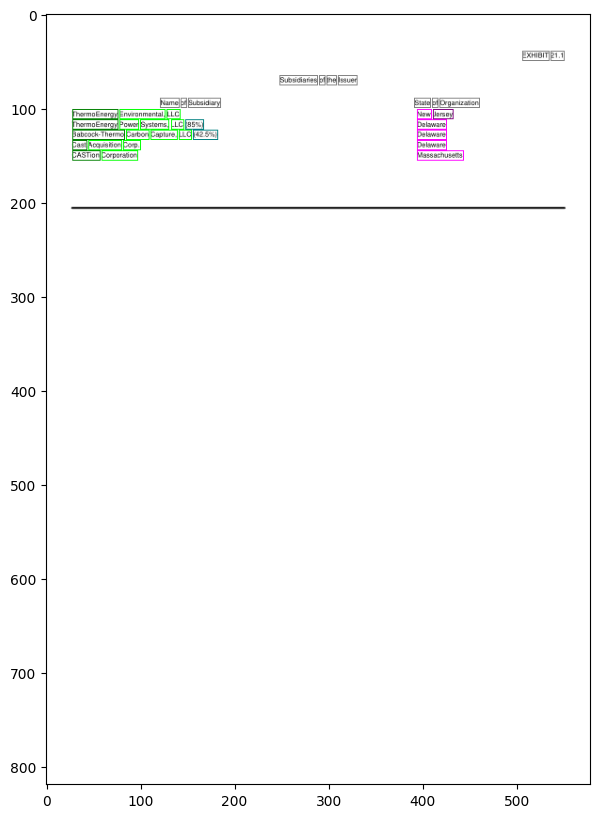

In [120]:
# fix to overlay boxes on pdf and color code it by label
coord_cols = ['top_left_x_pdf', 'top_left_y_pdf', 'bottom_right_x_pdf', 'bottom_right_y_pdf']
dpi = 70
display_img = np.array(_render_page(pg2, dpi=dpi))
for tag in id_to_label_small.keys():
    subset = txt2[txt2[label_col] == tag]
    bboxes = pdf_coords_to_pixel_coords(subset[coord_cols].values, dpi=dpi)
    display_img = overlay_bboxes(display_img, bboxes, color=id_to_color[tag])
display_img_array(display_img, figsize=(10, 10))

In [121]:
txt2.loc[:, "id"] = 1
output_df = pd.concat([output_df, txt2])

# Combine into one dataframe

In [31]:
# for now make image a filename
output_df = pd.DataFrame(columns=["tokens", "bboxes", "ner_tags", "image"])

In [20]:
doc_id = 0

In [21]:
txt.loc[:, "id"] = doc_id

In [35]:
output_df["tokens"] = txt.groupby("id")["text"].apply(list)
output_df["ner_tags"] = txt.groupby("id")["ner_tag"].apply(list)

In [71]:
output_df.loc[[0]]

,tokens,bboxes,ner_tags,image
id,,,,
0,"[Exhibit 21.1, WISCONSIN ELECTRIC POWER COMPAN...","[504.79117, 83.47444, 565.92926, 98.621445, 18...","[0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 2, 4, 6, 2, 4, ...",NaN


In [82]:
bbox_cols = ["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]
matrices = {}
for _, group in txt.groupby('id'):
    bbox = group[bbox_cols].values
    matrix = np.reshape(bbox, (len(group), len(bbox_cols)))
    matrices[group.iloc[0]['id']] = matrix

In [87]:
# this isn't so nice, what does the model want as input?
for i, arr in matrices.items():
    output_df.loc[i, "bboxes"] = arr

ValueError: Must have equal len keys and value when setting with an ndarray

In [63]:
# format bboxes to have x1, y1, x2, y2
txt["bboxes"] = txt[["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]].astype(str).agg(', '.join, axis=1)

In [65]:
output_df["bboxes"] = txt.groupby("id")["bboxes"].apply(list)

In [66]:
output_df

,tokens,bboxes,ner_tags,image
id,,,,
0,"[Exhibit 21.1, WISCONSIN ELECTRIC POWER COMPAN...","[504.79117, 83.47444, 565.92926, 98.621445, 18...","[0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 2, 4, 6, 2, 4, ...",NaN


# Try vendoring DocAI
https://medium.com/@matt.noe/tutorial-how-to-train-layoutlm-on-a-custom-dataset-with-hugging-face-cda58c96571c

In [123]:
bbox_cols = ["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]

In [125]:
# convert dataframe/dictionary into NER format
# document_annotation_to_ner https://github.com/butlerlabs/docai/blob/main/docai/annotations/ner_utils.py
# complete dataset is a list of dicts, with one dict for each doc
n_docs = 2
ner_annotations = []
images = [full_pg_img, full_pg_img2]
for i in range(n_docs):
        annotation = {
            "id": i, 
            "tokens": output_df.groupby("id")["text"].apply(list).loc[i], 
            "ner_tags": [id_to_label_small[n] for n in output_df.groupby("id")["ner_tag"].apply(list).loc[i]],
            "bboxes": output_df.loc[output_df["id"] == i, :][bbox_cols].values.tolist(),
            "image": images[i]
        }
        ner_annotations.append(annotation)

In [127]:
# normalize NER notation for LayoutLM
# https://github.com/butlerlabs/docai/blob/main/docai/annotations/layoutlm_utils.py
def normalize_bounding_box(bbx):
    normalize_bounding_box = list(map(lambda point: int(point * 1000), bbx))
    return normalize_bounding_box

def normalize_ner_annotation_for_layoutlm(annotation):
    """
    Normalize the bounding boxes by 1000 to match LayoutLM expected bounding box format
    """
    normalized_bbxs = list(map(normalize_bounding_box, annotation["bboxes"]))
    return {
        "id": annotation["id"],
        "tokens": annotation["tokens"],
        # Normalize NER bounding boxes by 1000 as LayoutLM expects
        "bboxes": normalized_bbxs,
        "ner_tags": annotation["ner_tags"],
        "image": annotation["image"],
    }

In [43]:
# not sure if we need to actually normalize, Hugging Face expects bboxes between 0 and 1000
# and they appear to already be that way
# norm_ner_annotations = normalize_ner_annotation_for_layoutlm(ner_annotations)

In [128]:
dataset = Dataset.from_list(ner_annotations)

In [129]:
dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'bboxes', 'image'],
    num_rows: 2
})

# Fine-tune Layout LM model

In [130]:
label_list = list(id_to_label_small.values())
label_list

['O',
 'B-Subsidiary',
 'I-Subsidiary',
 'B-Loc',
 'I-Loc',
 'B-Own_Per',
 'I-Own_Per']

In [131]:
column_names = dataset.column_names

In [132]:
id_to_label_small

{0: 'O',
 1: 'B-Subsidiary',
 2: 'I-Subsidiary',
 3: 'B-Loc',
 4: 'I-Loc',
 5: 'B-Own_Per',
 6: 'I-Own_Per'}

In [70]:
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

In [71]:
class_label = ClassLabel(names=label_list)

In [51]:
# update this split size when there are more than 2 docs
dataset = dataset.train_test_split(test_size=0.5)

In [52]:
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base-uncased")
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def convert_ner_tags_to_id(ner_tags):
    return [label2id[ner_tag] for ner_tag in ner_tags]

# This function is used to put the Dataset in its final format for training LayoutLM
def prepare_dataset(annotations):
    images = annotations['image']
    words = annotations['tokens']
    boxes = annotations['bboxes']
    # Map over labels and convert to numeric id for each ner_tag
    ner_tags = [convert_ner_tags_to_id(ner_tags) for ner_tags in annotations['ner_tags']]

    encoding = processor(images, words, boxes=boxes, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

In [53]:
# Define features for use training the model 
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Prepare our train & eval dataset

train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [54]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> EXHIBIT 21.1 Subsidiaries of the Issuer Name of Subsidiary State of Organization ThermoEnergy Environmental, LLC New Jersey ThermoEnergy Power Systems, LLC (85%) Delaware Babcock-Thermo Carbon Capture, LLC (42.5%) Delaware Cast Acquisition Corp. Delaware CASTion Corporation Massachusetts</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [55]:
train_dataset.set_format("torch")

In [56]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [57]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> Exhibit 21.1 WISCONSIN ELECTRIC POWER COMPANY SUBSIDIARIES AS OF DECEMBER 31, 2016 The following table includes the subsidiaries of WE, an electric, natural gas, and steam utility incorporated in the state of Wisconsin, as well as the percent of ownership, as of December 31, 2016. WE is a subsidiary of WEC Energy Group, Inc. Subsidiary State of Incorporation or Organization Percent Ownership ATC Management, Inc. * Wisconsin 26.24% American Transmission Company LLC * Wisconsin 23.04% Bostco LLC Wisconsin 100% * On January 1, 2017, we transferred our ownership interest in ATC Management, Inc. and American Transmission Company LLC to to another subsidiary of WEC Energy Group.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [63]:
metric = load_metric("seqeval")

/var/folders/c0/5zrbrqhx17d5jm6t03bw2nkw0000gn/T/ipykernel_77237/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [64]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [72]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [74]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [75]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,1.036757,0.500000,0.666667,0.571429,0.681818
200,No log,1.086099,0.461538,0.666667,0.545455,0.681818
300,No log,1.121462,0.461538,0.666667,0.545455,0.681818
400,No log,1.147209,0.461538,0.666667,0.545455,0.681818
500,0.028700,1.168161,0.461538,0.666667,0.545455,0.681818
600,0.028700,1.189763,0.461538,0.666667,0.545455,0.681818
700,0.028700,1.202609,0.461538,0.666667,0.545455,0.681818
800,0.028700,1.209763,0.461538,0.666667,0.545455,0.681818
900,0.028700,1.219576,0.461538,0.666667,0.545455,0.681818
1000,0.000300,1.220299,0.461538,0.666667,0.545455,0.681818


/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:977: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1000, training_loss=0.014478846237063407, metrics={'train_runtime': 1235.4401, 'train_samples_per_second': 1.619, 'train_steps_per_second': 0.809, 'total_flos': 263605343232000.0, 'train_loss': 0.014478846237063407, 'epoch': 1000.0})